#### Install Required Libraries

In [ ]:
!pip install tensorflow
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

#### Import Required Libraries

In [ ]:
import os
from pathlib import Path
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from tensorflow.keras.layers import GlobalAveragePooling2D

#### Load MRI Dataset

In [16]:
# Set the path to your dataset
dataset_path = Path("/home/khizra/Documents/ml_sp/end_to_end/dataset")
train_dir = dataset_path / "Training"
test_dir = dataset_path / "Testing"

In [17]:
train_data_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir,label)):
        train_data_paths.append(os.path.join(train_dir,label,image))
        train_labels.append(label)

train_data_paths, train_labels = shuffle(train_data_paths, train_labels)

In [ ]:
train_labels

In [19]:
test_data_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir,label)):
        test_data_paths.append(os.path.join(test_dir,label,image))
        test_labels.append(label)

test_data_paths, test_labels = shuffle(test_data_paths, test_labels)

#### Data Visualization

In [20]:
import matplotlib.pyplot as plt

random_indices = random.sample(range(len(train_data_paths)),10)
random_indices

[1536, 2812, 3877, 3429, 3037, 244, 994, 2637, 422, 2537]

In [ ]:
print(len(train_data_paths))
print(len(test_data_paths))

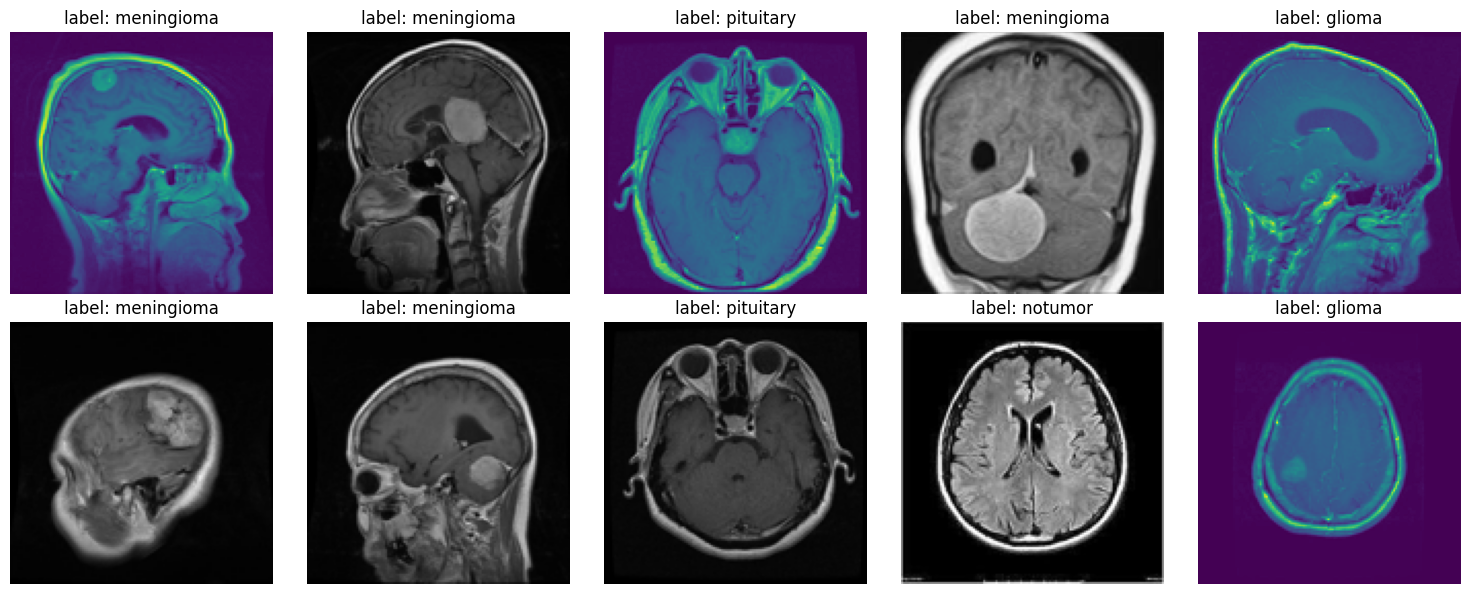

In [22]:
fig, axes = plt.subplots(2,5, figsize=(15,6))
axes = axes.ravel()

for i, img_index in enumerate(random_indices):
    img_path = train_data_paths[img_index]
    img = Image.open(img_path)
    img = img.resize((128,128))

    # Display Images
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"label: {train_labels[img_index]}")

plt.tight_layout()
plt.show()


#### Compute Class Weights to Handle Imbalanced Datasets

In [28]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',   # auto-compute weights based on dataset
    classes=np.unique(encoded_train_labels),
    y=encoded_train_labels
)
class_weights = dict(enumerate(class_weights))


#### Data Loading & Augmentation

In [29]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

def open_images(paths, augment=False):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = np.array(image) / 255.0  # normalize
        if augment:  # only apply augmentation during training
            image = augment_image(image)
        images.append(image)
    return np.array(images)


# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths, augment=True)
            batch_labels = labels[i:i + batch_size]
            batch_labels_encoded = encode_label(batch_labels)
            
            # compute sample weights
            batch_sample_weights = np.array([class_weights[label] for label in batch_labels_encoded])
            
            yield batch_images, batch_labels_encoded, batch_sample_weights



#### Transfer Learning with VGG16 for Image Classification

In [ ]:
IMAGE_SIZE =128
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-15:]:
    layer.trainable = True

model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

batch_size=20
steps=int(len(train_data_paths)/batch_size)
epochs=10

history_head = model.fit(
    open_images(train_data_paths, augment=True),
    encode_label(train_labels),
    batch_size=20,
    epochs=10,batch_size=20
steps=int(len(train_data_paths)/batch_size)
epochs=5

    validation_data=(open_images(test_data_paths, augment=False), encode_label(test_labels)),
    class_weight=class_weights,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)


#### Plotting Model Training Accuracy and Loss

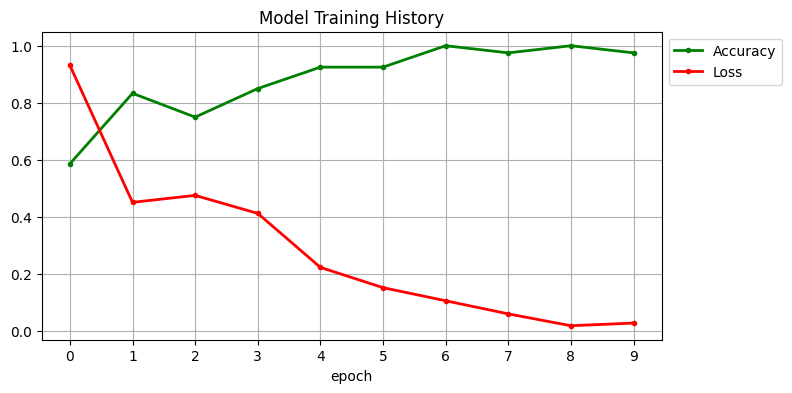

In [22]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

#### Evaluating Model Performance with Classification Report

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_data_paths, augment=False)

test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

#### Confusion Matrix Visualization for Model Predictions

In [ ]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#### ROC Curve and AUC for Multi-Class Classification

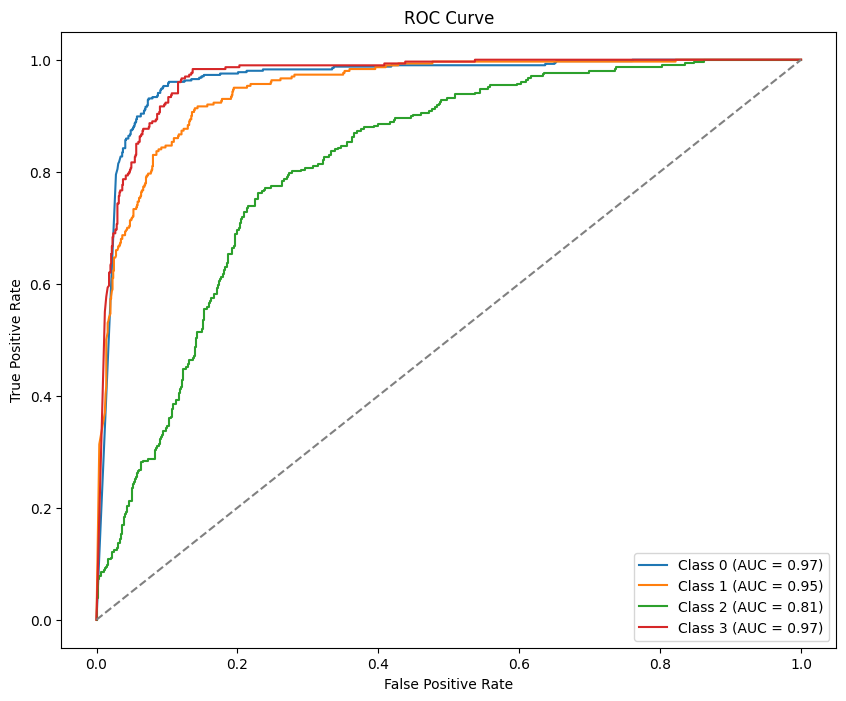

In [28]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

#### Save Trained Model

In [29]:
# Save the entire model
model.save('model.h5')

#### Load Trained Model

In [30]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

#### Tumor Detection and Visualization on a Single Image

In [31]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


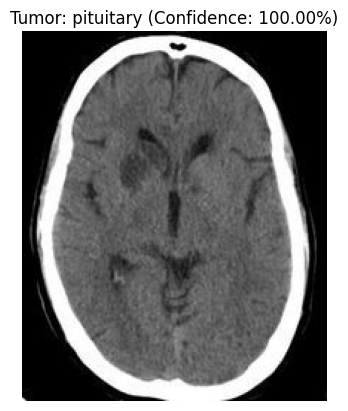

In [36]:
# Example usage
image_path = dataset_path / 'Testing/notumor/Te-no_0010.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)